# Diferenciální evoluce

In [593]:
import numpy as np
import matplotlib.pyplot as plt

## Testovací funkce

In [594]:
def sphere_function(x):
    return np.sum(x**2)

def rastrigins_function(x):
    return 10 * len(x) + np.sum(x**2 - 10 * np.cos(2 * np.pi * x))

## Mutační strategie

In [595]:
def rand_1_mutation(population, current_index, F):
    """
    Rand/1 mutacni strategie

    Parametry:
        population - populace    
        current_index - aktualni index, aktualne zvoleny jedinec
        F - mutacni konstanta
    """
    idlist = [idx for idx in range(len(population)) if idx != current_index]
    r1, r2, r3 = np.random.choice(idlist, 3, replace=False)
    return population[r1] + F * (population[r2] - population[r3])

def best_1_mutation(population, current_index, F, best_index):
    """
    Best/1 mutacni strategie

    Parametry:
        population - populace
        current_index - aktualni index, aktualne zvoleny jedinec
        F - mutacni konstanta
        best_index - index nejlepsiho jedince
    """
    idlist = [idx for idx in range(len(population)) if idx != current_index]
    r1, r2 = np.random.choice(idlist, 2, replace=False)
    return population[best_index] + F * (population[r1] - population[r2])

def current_to_rand_1_mutation(population, current_index, F):
    """
    Current-to-rand/1 mutacni strategie

    Parametry:
        population - populace
        current_index - aktualni index, aktualne zvoleny jedinec
        F - mutacni konstanta
    """
    r1, r2, r3 = np.random.choice(len(population), 3, replace=False)
    K = 0.5 * (F + 1)
    return population[current_index] + K * (population[r1] - population[current_index]) + F * (population[r2] - population[r3])

# Evoluční algoritmus DE

In [596]:
# type evolucnich algoritmu
DE_TYPE_RAND = 0
DE_TYPE_BEST = 1
DE_TYPE_JDE = 2
DE_TYPE_EPSDE = 3


class DE_Population:

    # indexy pro dodatecny parametry jedince
    __Fx = 0    # F parametr
    __CRx = 1   # CR parametr
    __Mx = 2    # Mutacni strategie

    def __init__(self, type, dimension, CR, F):
        """
        Vytvori tridu pro diferencialni evoluci

        Parametry:
            type - typy DE algoritmu (DE_TYPE_RAND, DE_TYPE_BEST, DE_TYPE_JDE, DE_TYPE_EPSDE)
            dimension - Dimenze reseni
            CR - prah krizeni
            F - mutacni konstanta
        """
        self.type = type
        self.dimension = dimension
        self.CR = CR
        self.F = F
        self.fitness_function = None
        self.population_size = 0
        self.mutation_strategy = [rand_1_mutation, best_1_mutation, current_to_rand_1_mutation]

    def create_population(self, population_size, bounds):
        """
        Vytvori populaci

        Parametry:
            population_size - velikost populace
            bounds - inicializacni rozsah populace   
        """
        self.population_size = population_size
        self.population = np.random.uniform(bounds[0], bounds[1], size=(self.population_size, self.dimension))

        if self.type == DE_TYPE_JDE:
            for i in range(len(self.population)):
                self.population[i][self.__Fx] = self.F
                self.population[i][self.__CRx] = self.CR
        elif self.type == DE_TYPE_EPSDE:
            for i in range(len(self.population)):
                self.population[i][self.__Fx] = self.F
                self.population[i][self.__CRx] = self.CR
                self.population[i][self.__Mx] = np.random.randint(0, len(self.mutation_strategy))

    def set_fitness_function(self, func):
        """
        Priradi fitness funkci evolucnimu algoritmu

        Parametry:
            func - fitness funkce  
        """
        self.fitness_function = func

    def calculate_population_statistics(self):
        """
        Vypocita statistiky pro aktuálni populaci

        Returns:
            min_value: Minimalni hodnota fitness v populaci
            max_value: Maximalni hodnota fitness v populaci
            avg_value: Průměrná hodnota fitness v populaci
            std_value: Smerodatna odchylka hodnot fitness v populaci
            median_value: Median hodnot fitness v populaci
        """
        fitness_values = [self.fitness_function(individual) for individual in self.population]
        min_value = np.min(fitness_values)
        max_value = np.max(fitness_values)
        avg_value = np.mean(fitness_values)
        std_value = np.std(fitness_values)
        median_value = np.median(fitness_values)
        return min_value, max_value, avg_value, std_value, median_value

    def run_evolution(self, generations):
        if self.fitness_function is None:
            print("Fitness function is not defined!!!!")
            return

        convergence_curve = []
        best_index = 0

        for gen in range(generations):
            new_population = []

            if self.type == DE_TYPE_BEST or self.type == DE_TYPE_EPSDE:
                best_index = self.__find_best()

            for i in range(self.population_size):

                # zpracovani jedne iterace evolucniho algoritmu v zavyslosti na jeho typu
                if self.type == DE_TYPE_EPSDE:
                    new_individual = self.__epsde_evolution(i, best_index)
                elif self.type == DE_TYPE_JDE:
                    new_individual = self.__jde_evolution(i)
                elif self.type == DE_TYPE_BEST:
                    new_individual = self.__best_evolution(i, best_index)
                else:
                    new_individual = self.__rand_evolution(i)

                # selekce 
                if self.fitness_function(new_individual) < self.fitness_function(self.population[i]):
                    # nove vytvoreny jedinec
                    new_population.append(new_individual)
                else:
                    # nahodna reinicializace 
                    if self.type == DE_TYPE_EPSDE:
                        self.__reinit_epsde_F_CR_M(self.population[i])

                    # rodic (predchozi jedinec bez zmeny)
                    new_population.append(self.population[i])
            
            self.population = np.array(new_population)
            convergence_curve.append(self.fitness_function(self.population.min(axis=0)))

        return self.population, convergence_curve

    def __rand_evolution(self, current_index):
        """
        Metoda pro RAND1
        """
        # aplikace mutacni strategie (na indexu 0 je rand/1 mutacni strategie)
        mutation_vector = self.mutation_strategy[0](self.population, current_index, self.F)
        # krizeni
        return self.__binomial_crossover(self.population[current_index], mutation_vector, self.CR)

    def __best_evolution(self, current_index, best_index):
        """
        Metoda pro BEST/1
        """
        # aplikace mutacni strategie (na indexu 1 je best/1 mutacni strategie)
        mutation_vector = self.mutation_strategy[1](self.population, current_index, self.F, best_index)
        # krizeni
        return self.__binomial_crossover(self.population[current_index], mutation_vector, self.CR)

    def __jde_evolution(self, current_index):
        """
        Metoda pro jDE
        """
        # re-inicializace hodnot parametru CR a F s pravděpodobnosti 0.1
        current_cr = self.population[current_index][self.__CRx]
        current_f = self.population[current_index][self.__Fx]
        if np.random.rand() < 0.1:
            current_cr = np.random.uniform(0, 1)
        if np.random.rand() < 0.1:
            current_f = np.random.uniform(0, 1)

        # CR a F je pouzite to ktere ma jedinec zakodovano v sobe
        # aplikace mutacni strategie
        mutation_vector = self.mutation_strategy[0](self.population, current_index, current_f)
        # krizeni
        new_individual = self.__binomial_crossover(self.population[current_index], mutation_vector, current_cr)

        # priradi jedinci CR a F pro dalsi generaci
        new_individual[self.__Fx] = current_f
        new_individual[self.__CRx] = current_cr

        return new_individual


    def __epsde_evolution(self, current_index, best_index):
        """
        Metoda pro EPSDE
        """

        # {strategie, F, CR} aktualniho jedince
        current_cr = self.population[current_index][self.__CRx]
        current_f = self.population[current_index][self.__Fx]
        ms_func_id = self.population[current_index][self.__Mx]
        ms_func = self.mutation_strategy[int(ms_func_id)]

        # aplikace mutacni strategie
        if ms_func == best_1_mutation:
            mutation_vector = ms_func(self.population, current_index, current_f, best_index)
        else:
            mutation_vector = ms_func(self.population, current_index, current_f)
        # krizeni
        new_individual = self.__binomial_crossover(self.population[current_index], mutation_vector, current_cr)

        # priradi jedinci {strategie, F, CR} pro dalsi generaci
        new_individual[self.__Fx] = current_f
        new_individual[self.__CRx] = current_cr
        new_individual[self.__Mx] = ms_func_id

        return new_individual
    
    def __reinit_epsde_F_CR_M(self, new_individual):
        """
        Nahodna reinicialize F, CR a vybrane mutacni strategie
        """
        new_individual[self.__Fx] = np.random.choice([0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
        new_individual[self.__CRx] = np.random.choice([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
        new_individual[self.__Mx] = np.random.randint(0, len(self.mutation_strategy))

    def __binomial_crossover(self, target, mutant, crossover_rate):
        """
        Binarni krizeni

        Parametry:
            target - aktivni jedinec (rodic)
            mutant - mutacni vektor
            crossover_rate - prah krizeni
        """
        crossover_mask = np.random.rand(len(target)) < crossover_rate
        return np.where(crossover_mask, mutant, target)
    
    def __find_best(self):
        """
        V populaci najde jedince s nejlepsi hodnotou fitness funkce a navrati jeho index
        """
        best_fitness = self.fitness_function(self.population[0])
        best_index = 0
        for i, individual in enumerate(self.population):
            current_fitness = self.fitness_function(individual)
            if current_fitness < best_fitness:
                best_fitness = current_fitness
                best_index = i
        return best_index

## Nastavení

In [597]:
# pocet generaci
generations = 250

# velikost populace
population_size = 30

# dimenze
dimension = 10

# inicializacni rozsah populace
bounds = (10.0, -10.0)

# prah krizeni
default_CR = 0.8

# mutacni konstatnta
default_F = 0.5

## Test DE algoritmů na funkci Rastrigin

In [598]:
# Rand/1
pop1 = DE_Population(type=DE_TYPE_RAND, dimension=dimension, CR=default_CR, F=default_F)
pop1.create_population(population_size=population_size, bounds=bounds)
pop1.set_fitness_function(rastrigins_function)
_, conv_curve_rand1 = pop1.run_evolution(generations)

# Best/1
pop2 = DE_Population(type=DE_TYPE_BEST, dimension=dimension, CR=default_CR, F=default_F)
pop2.create_population(population_size=population_size, bounds=bounds)
pop2.set_fitness_function(rastrigins_function)
_, conv_curve_best1 = pop2.run_evolution(generations)

# jDE
pop3 = DE_Population(type=DE_TYPE_JDE, dimension=dimension, CR=0.9, F=0.5)
pop3.create_population(population_size=population_size, bounds=bounds)
pop3.set_fitness_function(rastrigins_function)
_, conv_curve_jde = pop3.run_evolution(generations)

# EPSDE
pop4 = DE_Population(type=DE_TYPE_EPSDE, dimension=dimension, CR=default_CR, F=default_F)
pop4.create_population(population_size=population_size, bounds=bounds)
pop4.set_fitness_function(rastrigins_function)
_, conv_curve_epsde = pop4.run_evolution(generations)

In [599]:
pop4 = DE_Population(type=DE_TYPE_EPSDE, dimension=dimension, CR=default_CR, F=default_F)
pop4.create_population(population_size=population_size, bounds=bounds)
pop4.set_fitness_function(rastrigins_function)
_, conv_curve_epsde = pop4.run_evolution(generations)

## Statistika

In [600]:
min_val, max_val, avg_val, std_val, median_val = pop1.calculate_population_statistics()
print(f"[RAND/1] >> Min: {min_val:.5f}, Max: {max_val:.5f}, Avg: {avg_val:.5f}, Std: {std_val:.5f}, Median: {median_val:.5f}")

min_val, max_val, avg_val, std_val, median_val = pop2.calculate_population_statistics()
print(f"[BEST/1] >> Min: {min_val:.5f}, Max: {max_val:.5f}, Avg: {avg_val:.5f}, Std: {std_val:.5f}, Median: {median_val:.5f}")

min_val, max_val, avg_val, std_val, median_val = pop3.calculate_population_statistics()
print(f"[jDE] >> Min: {min_val:.5f}, Max: {max_val:.5f}, Avg: {avg_val:.5f}, Std: {std_val:.5f}, Median: {median_val:.5f}")

min_val, max_val, avg_val, std_val, median_val = pop4.calculate_population_statistics()
print(f"[EPSDE] >> Min: {min_val:.5f}, Max: {max_val:.5f}, Avg: {avg_val:.5f}, Std: {std_val:.5f}, Median: {median_val:.5f}")

[RAND/1] >> Min: 29.30391, Max: 59.32438, Avg: 45.72406, Std: 8.09746, Median: 46.62300
[BEST/1] >> Min: 50.75793, Max: 50.76503, Avg: 50.76003, Std: 0.00121, Median: 50.75995
[jDE] >> Min: 1.10664, Max: 9.08677, Avg: 3.66466, Std: 2.02567, Median: 3.07304
[EPSDE] >> Min: 7.93183, Max: 43.03692, Avg: 25.80868, Std: 8.91902, Median: 25.99688


## Konvergenční graf

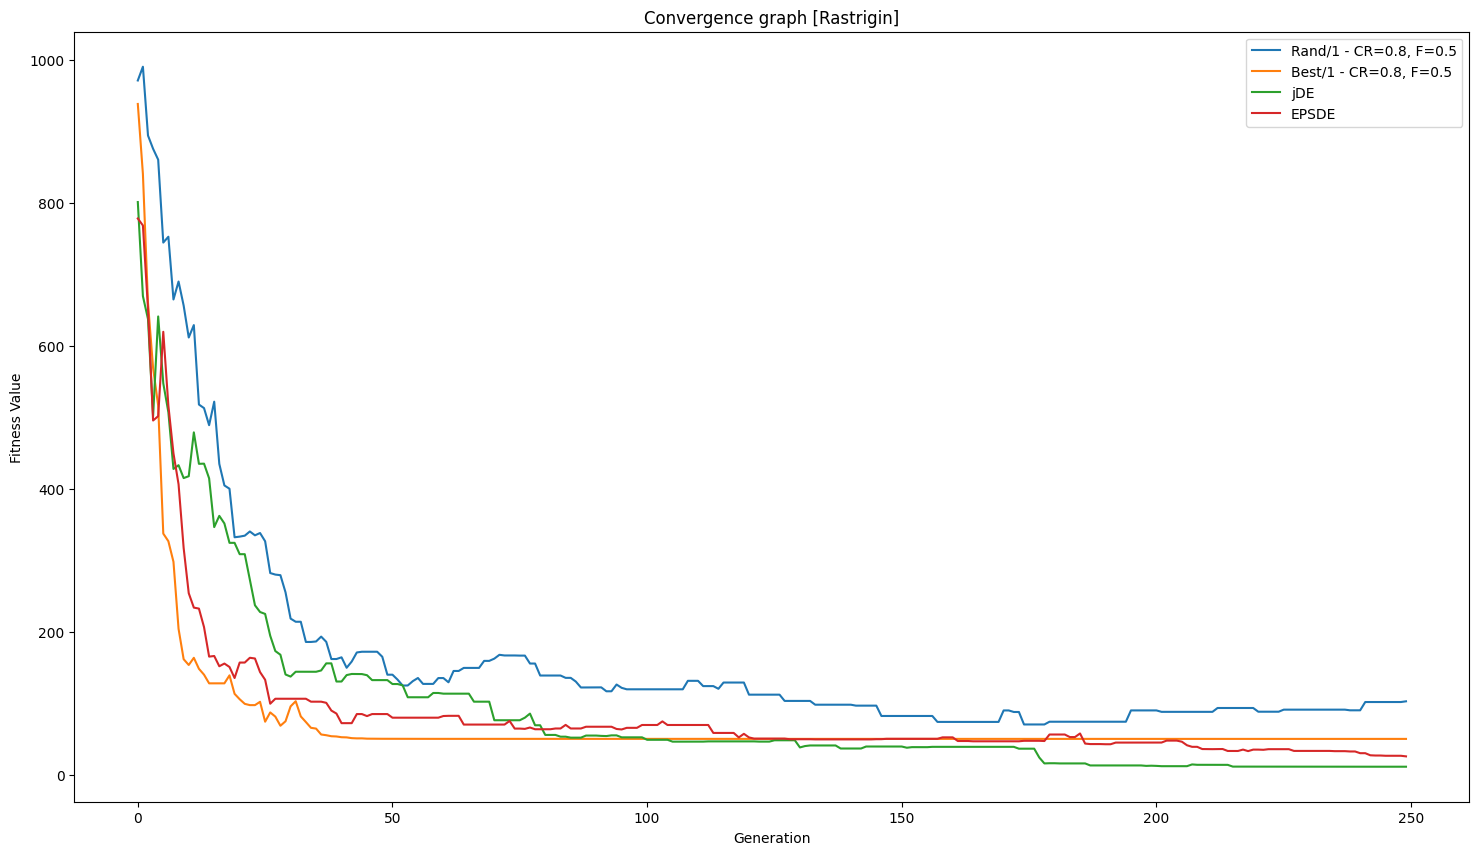

In [601]:
plt.figure(figsize=(18, 10))
plt.plot(conv_curve_rand1, label=f'Rand/1 - CR={default_CR}, F={default_F}')
plt.plot(conv_curve_best1, label=f'Best/1 - CR={default_CR}, F={default_F}')
plt.plot(conv_curve_jde, label=f'jDE')
plt.plot(conv_curve_epsde, label=f'EPSDE')
plt.xlabel('Generation')
plt.ylabel('Fitness Value')
plt.legend()
plt.title('Convergence graph [Rastrigin]')
plt.show()

## Závěr

Cílem této úlohy byly implementovány 4 varianty DE algoritmu. Každá z těchto metod byla ověřena na testovací funkci "Rastrigin".

__Rand/1__ a __Best/1__ jsou jednoduché varianty DE algoritmu a také to jde znát na výsledcích a grafu. Výsledky byly horší ve srovnání s adaptivními variantami jDE a EPSDE. Rand/1 dosáhl ze všech úplně nejhorších výsledků. Best/1 byl na tom o poznání lépe, ale stálé nedosáhl tak přesných výsledků jako zbylé 2 pokročilejší varianty. Best/1 však konvergovala nejrychleji ze všech kde dosáhla svého minima a nasledně už byl graf konstatní (to je možne vidět u na nízkých hodnotach Std). 

__jDE__ varianta dosahovala nejlepších výsledků ve srovnání s ostatními. Měla výrazně nejnižší hodnotu fitness než ostatní. 

__EPSDE__ také dosahla dobrých výsledků, avšak vykazovala větší rozptyl a horší průměrnou hodnotu fitness ve srovnání s jDE.

